In [1]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from utils import gaussian, tricube, colormap, quartic, triweight

In [2]:
IMAGE_FOLDER = 'D:/mnt/data_source/cropped-apple-bb/images/'
GROUND_TRUTH_PATH = 'D:/mnt/data_source/cropped-apple-bb/ground-truth/ground_truth.json'

In [3]:
with open(GROUND_TRUTH_PATH) as f:
    ground_truth = json.load(f)

def get_roi(image_name):
    with open(GROUND_TRUTH_PATH) as f:
        ground_truth = json.load(f)
        
    for item in ground_truth:
        if item['name'] == image_name:
            image = cv2.imread(item['cropped_image_path'])
            
            height, width = image.shape[:2]
            coords = []
            for coord in item['crop_coordinates_ratio']:
                x, y, w, h = coord[0], coord[1], coord[2], coord[3]
                x1 = int((x - w / 2) * width)
                y1 = int((y - h / 2) * height)
                x2 = int((x + w / 2) * width)
                y2 = int((y + h / 2) * height)
                
                # Perform boundary checks
                x1 = max(0, min(x1, width - 1))
                y1 = max(0, min(y1, height - 1))
                x2 = max(0, min(x2, width - 1))
                y2 = max(0, min(y2, height - 1))
                
                coords.append((x1, y1, x2, y2))
    return coords

In [4]:
get_roi('23945062_20211025_223251_734.jpg')

[(203, 219, 373, 409),
 (284, 547, 334, 598),
 (671, 866, 716, 917),
 (768, 737, 811, 784),
 (769, 793, 810, 837)]

In [5]:
img = 'D:/mnt/data_source/cropped-apple-bb/images/23945062_20211025_201041_669.jpg'

In [5]:
def get_density_map(image_name='23945062_20211025_201041_669.jpg', sigma=10, kernel_type='gaussian', factor=3):
    
    # Load image, init density map, get coords etc.
    image = cv2.imread(f'{IMAGE_FOLDER}{image_name}')
    density_map = np.zeros(image.shape[:2], dtype=np.float32)
    coords = get_roi(image_name)
    
    for coord in coords:
        x1, y1, x2, y2 = coord
        # calculate width and height of the bounding box
        w = x2 - x1
        h = y2 - y1

        # Create 2D kernel
        kernel_size = (h, w) 
        
        if kernel_type == 'gaussian':
            kernel = gaussian(kernel_size, sigma)
        
        if kernel_type == 'tricube':
            # Pass bbox height as 'size' param for tricube
            kernel = tricube(max(h, w), factor)
            if h > w:
                kernel = kernel[:, :w]
            else:
                kernel = kernel[:h, :]

        # Apply kernel to density map 
        density_map[y1:y2, x1:x2] += kernel
        
    # Overlay the density_map heatmap in the original image
    overlay = colormap(density_map, image)
    # plt.axis('off')
    # plt.imshow(overlay)
        
    return overlay

In [6]:
FACTOR = 15
SIGMA = 15

In [7]:
tricube_kernel = get_density_map('23945062_20211104_125044_108.jpg', kernel_type='tricube', factor=FACTOR)

In [8]:
gaussian_kernel = get_density_map('23945062_20211104_125044_108.jpg', sigma=SIGMA)

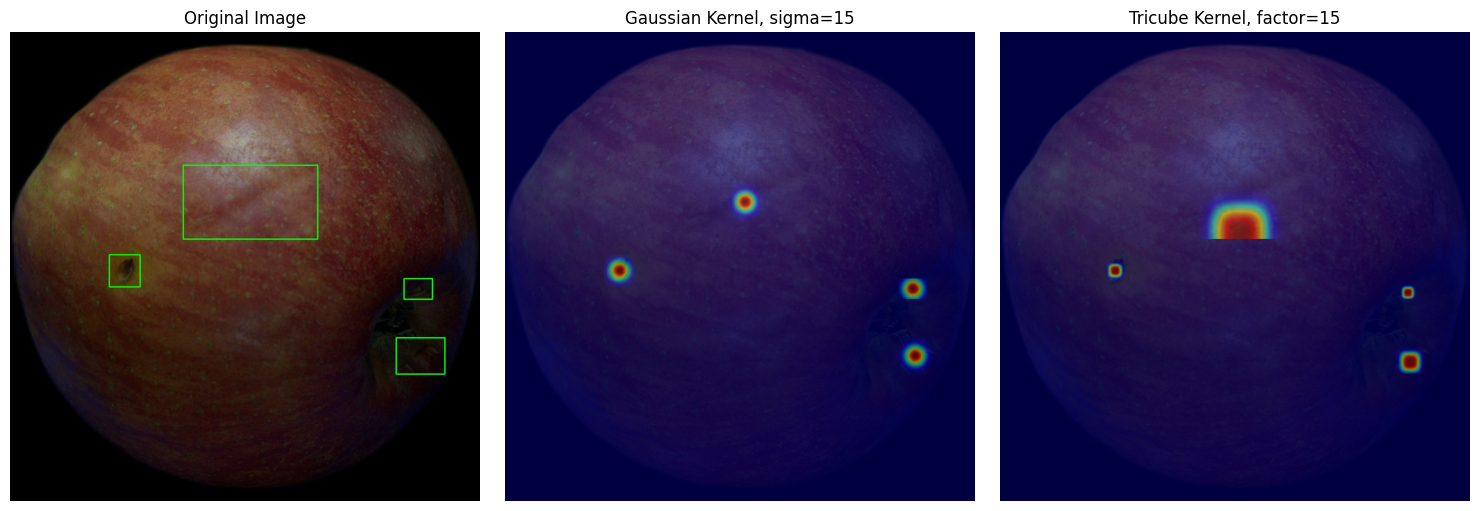

In [9]:
image_name='23945062_20211104_125044_108.jpg'
image = cv2.imread(f'D:/mnt/data_source/cropped-apple-bb/crop-images-bb/{image_name}')

# Plot kernels
fig, axs = plt.subplots(1,3, figsize=(15,5))

axs[0].imshow(image[:,:,::-1])
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(gaussian_kernel)
axs[1].set_title(f'Gaussian Kernel, sigma={SIGMA}')
axs[1].axis('off')

axs[2].imshow(tricube_kernel)  
axs[2].set_title(f'Tricube Kernel, factor={FACTOR}')
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [4]:
def get_density_map(image_name='23945062_20211025_201041_669.jpg', factor=3):
    
    # Load image, init density map, get coords etc.
    image = cv2.imread(f'{IMAGE_FOLDER}{image_name}')
    density_map = np.zeros(image.shape[:2], dtype=np.float32)
    coords = get_roi(image_name)
    
    for coord in coords:
        x1, y1, x2, y2 = coord
        # calculate width and height of the bounding box
        w = x2 - x1
        h = y2 - y1

        # Create 2D kernel
        kernel_size = (h, w) 
        
        kernel = quartic(kernel_size)

        # Apply kernel to density map 
        density_map[y1:y2, x1:x2] += kernel
        
        
    # Overlay the density_map heatmap in the original image
    print(np.mean(density_map))
    overlay = colormap(density_map, image)
    plt.axis('off')
    plt.imshow(density_map)
        
    return overlay

3.8146973e-06


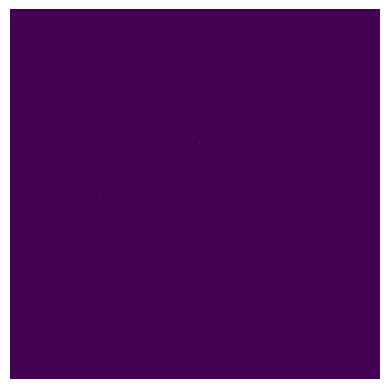

In [5]:
quartic_kernel = get_density_map('23945062_20211104_125044_108.jpg')